<a href="https://colab.research.google.com/github/lucastanger/classification_optimization/blob/main/classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison and Optimization of ML Classifiers using Sklearn

*   See [GitHub](https://github.com/lucastanger/classification_optimization) Repository for further information



In [1]:
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
# Necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_curve, accuracy_score, plot_roc_curve, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

sns.set_style("dark")

#Attribute Information:

Input variables:
### bank client data:
1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) <br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') <br>
5 - default: has credit in default? (categorical: 'no','yes','unknown') <br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown') <br> 
7 - loan: has personal loan? (categorical: 'no','yes','unknown') <br>
### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. <br>
### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

### Output variable (desired target):<br>
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')<br>


---


Für Testzwecke wurde eine Lösung erstellt, um alle verfügbaren Datensätze zu 
laden. Die Optimisierung wurde jedoch nur für den bank.csv Datensatz entwickelt, da die anderen viel zu groß sind.

In [2]:
# Load data from source

# data = pd.read_csv('https://gist.githubusercontent.com/lucastanger/0f54af9a99e3618e99d191b88991af5b/raw/faaffa81cfff769f9cef3e4f6bbddecb78fda40f/bank_full_dataset.csv', sep=";")
# data = pd.read_csv('https://gist.githubusercontent.com/lucastanger/3459c3aab432298799e5f512c4b38155/raw/595a25db7488a9893ad83eb33c54447cf45fe9ce/bank_dataset.csv', sep=";")
from io import BytesIO
from zipfile import ZipFile
from google.colab import output
from urllib.request import urlopen

file_num = 0
while file_num < 1 or file_num > 4:
  output.clear()
  print('Welche Datei soll geladen werden:\n<1> bank.csv\n<2> bank-full.csv\n<3> bank-additional.csv\n<4> bank-additional-full.csv\n')
  #file_num = int(input('Zahl hier eingeben: '))
  file_num = 1

if file_num == 1 or file_num == 2:
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
elif file_num == 3 or file_num == 4:
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'

filenames = {1: 'bank.csv',
             2: 'bank-full.csv',
             3: 'bank-additional/bank-additional.csv',
             4: 'bank-additional/bank-additional-full.csv'}

resp = urlopen(url)
zf = ZipFile(BytesIO(resp.read()))
data = pd.read_csv(zf.open(filenames[file_num]), sep=";")

data

Welche Datei soll geladen werden:
<1> bank.csv
<2> bank-full.csv
<3> bank-additional.csv
<4> bank-additional-full.csv



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [3]:
# Check frequency of target values
data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [4]:
# Show statistics for numerical data
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
# Select all data
X = data.iloc[:, :-1]
# Select target column
y = data.iloc[:, -1]

In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

# Iterate all categorical columns and transform them
for col in X.select_dtypes(include=np.object):
  X[col] = le.fit_transform(X[col]) 

X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,30,5,329,5,-1,0,3
4517,57,6,1,2,1,-3313,1,1,2,9,8,153,1,-1,0,3
4518,57,9,1,1,0,295,0,0,0,19,1,151,11,-1,0,3
4519,28,1,1,1,0,1137,0,0,0,6,3,129,4,211,3,1


In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize columns
scaler = StandardScaler()
# Fit scaler with input data
scaler.fit(X)
# Scale data
X_scaled = scaler.transform(X)
# Overwrite existing dataset with scaled data
X = pd.DataFrame(data=X_scaled, columns=X.columns)
# Check scaled data
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,-1.056270,1.716804,-0.246429,-1.644755,-0.130759,0.121072,-1.142051,-0.424756,-0.723642,0.374052,1.485414,-0.711861,-0.576829,-0.407218,-0.320413,0.444413
1,-0.772583,0.795246,-0.246429,-0.309038,-0.130759,1.118644,0.875617,2.354292,-0.723642,-0.596026,0.819288,-0.169194,-0.576829,2.989044,2.041734,-2.579961
2,-0.583458,-0.126313,1.421396,1.026680,-0.130759,-0.024144,0.875617,-0.424756,-0.723642,0.010273,-1.845220,-0.303898,-0.576829,2.899143,0.270124,-2.579961
3,-1.056270,-0.126313,-0.246429,1.026680,-0.130759,0.017726,0.875617,2.354292,1.495133,-1.566105,0.153161,-0.250017,0.387967,-0.407218,-0.320413,0.444413
4,1.686036,-1.047871,-0.246429,-0.309038,-0.130759,-0.472753,0.875617,-0.424756,1.495133,-1.323585,0.819288,-0.146102,-0.576829,-0.407218,-0.320413,0.444413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,-0.772583,0.795246,-0.246429,-0.309038,-0.130759,-0.583410,0.875617,-0.424756,-0.723642,1.707910,-0.179903,0.250315,0.709566,-0.407218,-0.320413,0.444413
4517,1.496912,0.488060,-0.246429,1.026680,7.647669,-1.573671,0.875617,2.354292,1.495133,-0.838546,0.819288,-0.427057,-0.576829,-0.407218,-0.320413,0.444413
4518,1.496912,1.409618,-0.246429,-0.309038,-0.130759,-0.374724,-1.142051,-0.424756,-0.723642,0.374052,-1.512157,-0.434754,2.639160,-0.407218,-0.320413,0.444413
4519,-1.245394,-1.047871,-0.246429,-0.309038,-0.130759,-0.094925,-1.142051,-0.424756,-0.723642,-1.202326,-0.846030,-0.519426,0.387967,1.710451,1.451197,-1.571836


In [8]:
# Tranform target variable to binary values
transformer = LabelBinarizer().fit(y)

y = transformer.transform(y)

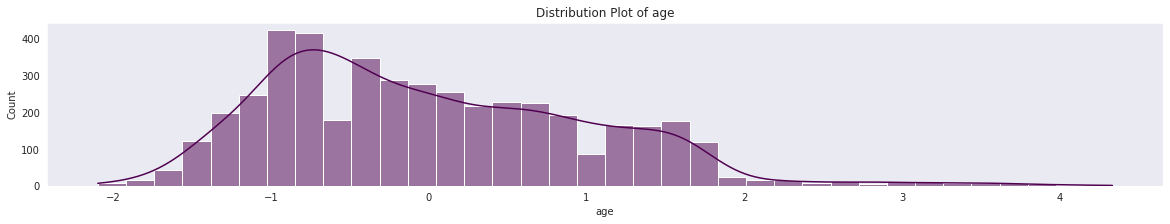

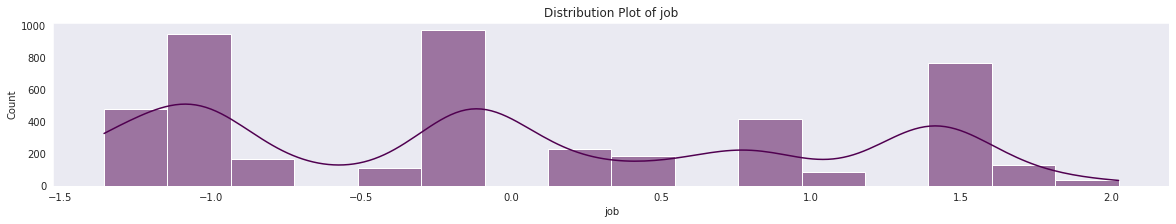

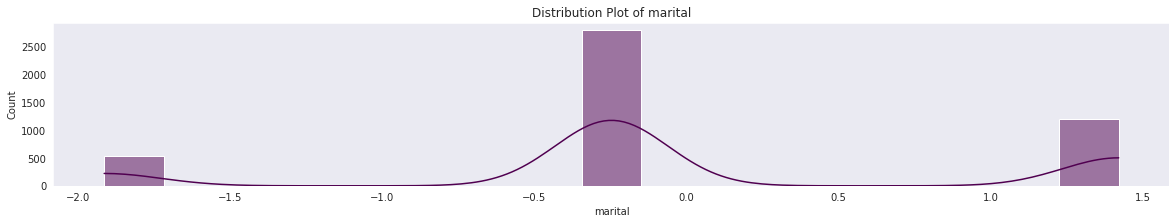

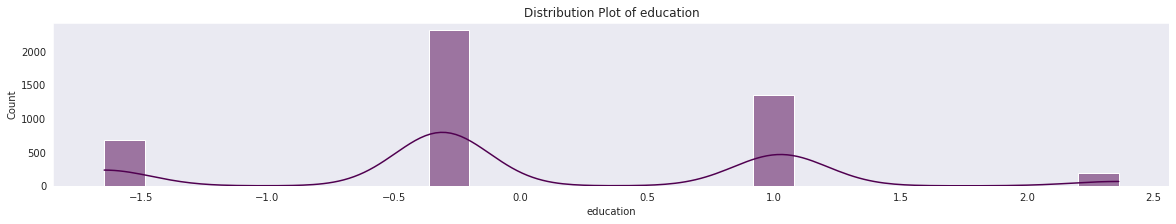

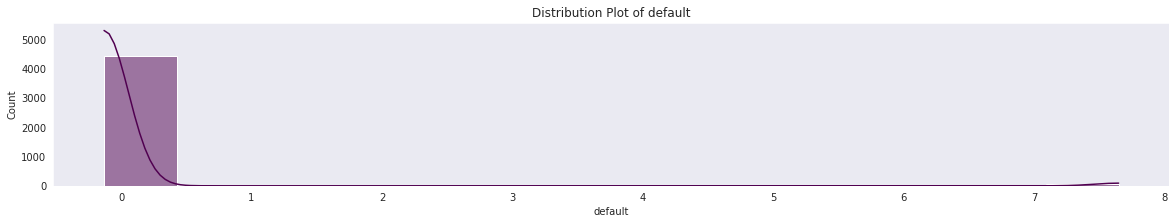

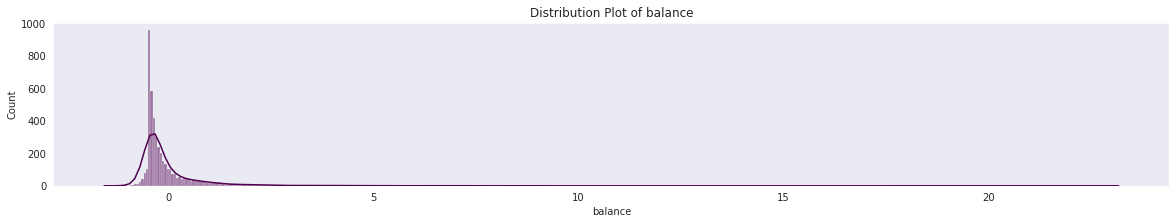

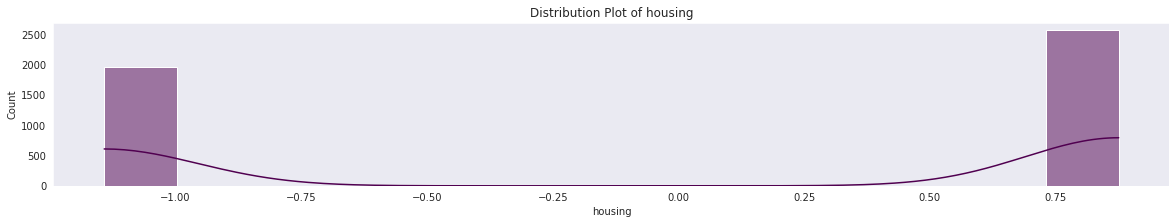

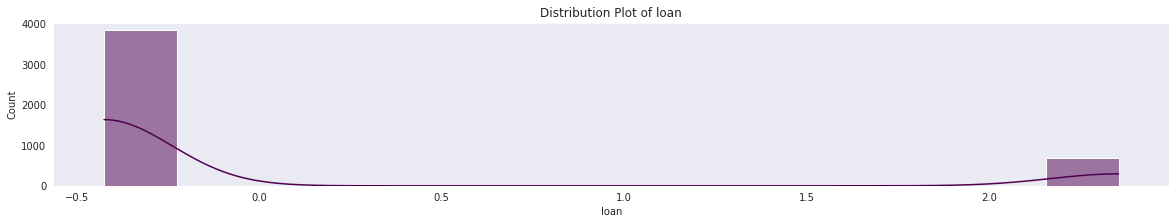

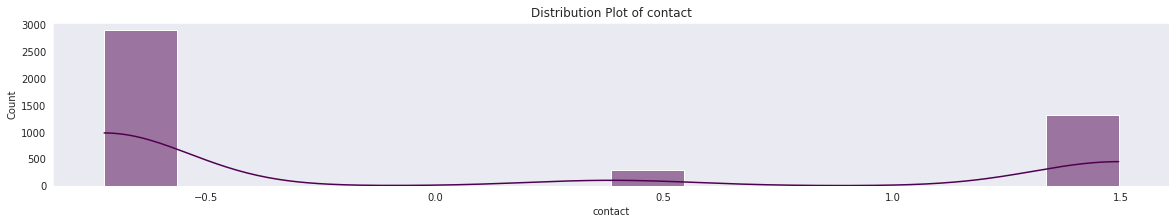

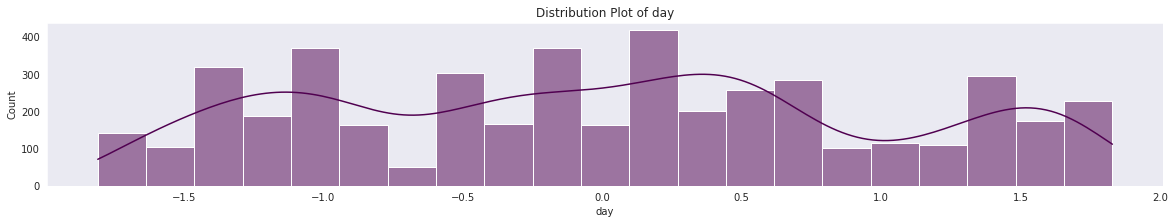

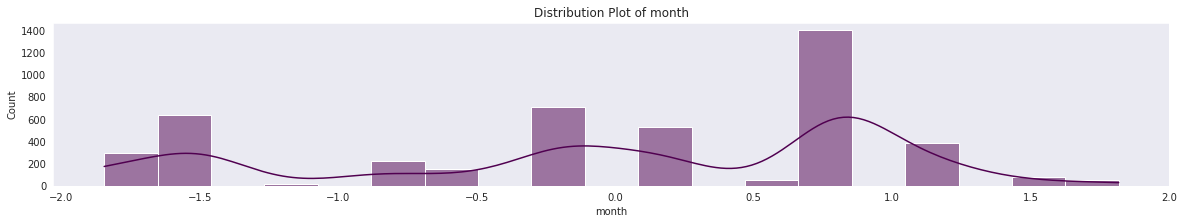

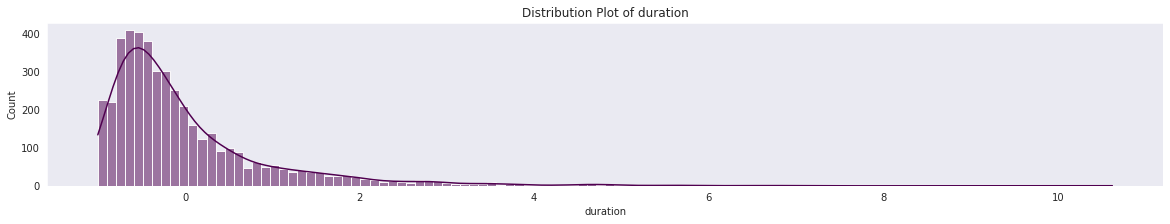

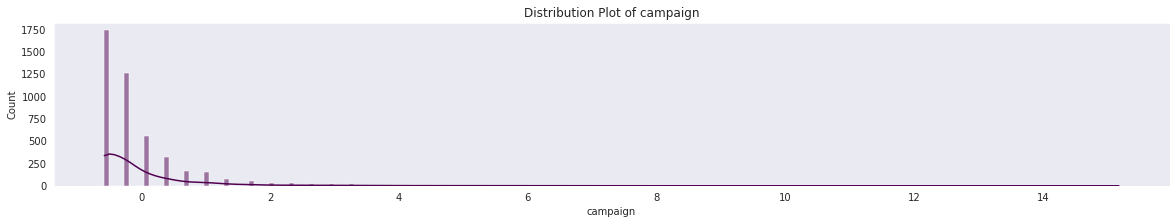

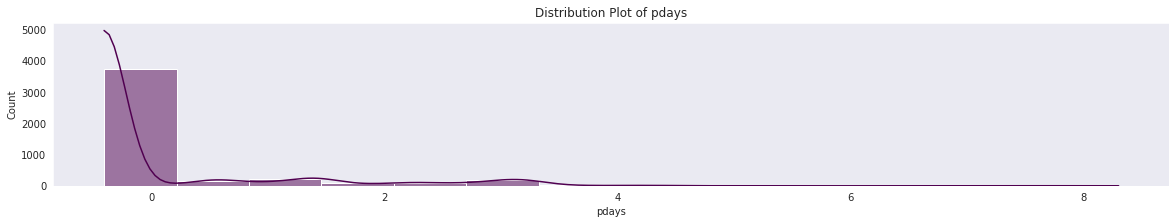

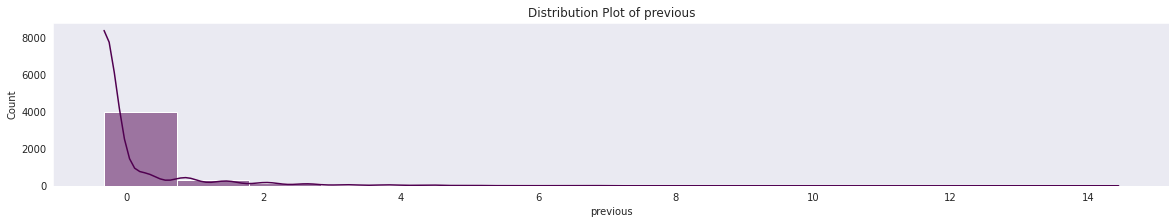

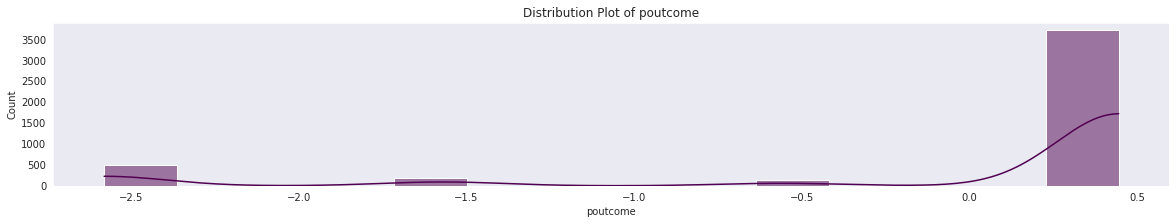

In [9]:
# Analyze all columns
# Iterate all colums
for entry in X: 
  plt.figure(figsize=(20,3))

  plt.subplot()
  # Create histogram with distribution plot
  sns.histplot(data=X[entry], color='#500050', kde=True)
  # Set title
  plt.title(f'Distribution Plot of {entry}')
  # Display plot
  plt.show()

In [10]:
# Print shapes of data
print(X.shape)
print(y.shape)

(4521, 16)
(4521, 1)


# Classification

In [11]:
# Import classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [12]:
# Training + Validierung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [13]:
# Convert y_train into np.array
y_t = np.array(y_train)

In [14]:
# empty list for fitted models
models = []

# Instances of all models
mod = [
       SVC(kernel='linear'), 
       SVC(kernel='rbf'), 
       SVC(kernel='sigmoid'), 
       SVC(kernel='poly'), 
       KNeighborsClassifier(), 
       SGDClassifier(), 
       GaussianNB(), 
       DecisionTreeClassifier(), 
       AdaBoostClassifier()]

In [15]:
# Iterate all models and fit them with training data
for m in mod:
  m.fit(X_train, y_t.ravel())
  y_pred = m.predict(X_test)
  # Append models to models list
  models.append(m)

In [16]:
# Prepare GridSearchCV
# Create parameter list for each model
from sklearn.model_selection import GridSearchCV

svm_params = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
              'degree': (2,3),
              'gamma': ('auto', 'scale'),
              'shrinking': (True, False),
              'decision_function_shape': ('ovo', 'ovr')}

knn_params = {'n_neighbors': [5,10,15],
              'weights': ('uniform', 'distance'),
              'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
              'leaf_size': [20,30,40,50]}

sgd_params = {'loss':('hinge', 'log'), 
              'penalty': ('l2', 'l1', 'elasticnet'),
              'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 5e-4, 1e-5],
              'max_iter': np.arange(start = 700, stop = 1500, step = 100)}

nb_params = {}

tree_params = {'criterion': ('gini', 'entropy'),
               'splitter': ('best', 'random')}

ada_params = {'n_estimators': np.arange(start = 10, stop = 100, step = 10),
              'algorithm': ('SAMME', 'SAMME.R')}

params = [svm_params, knn_params, sgd_params, nb_params, tree_params, ada_params]

# Optimierung der Modelle durch Evaluierung der Parameter

In [17]:
# Empty list for storage of best models
bestModels = []
# Instances of Classification models to be optimized
modelsToOptimize = [SVC(), KNeighborsClassifier(), SGDClassifier(), GaussianNB(), DecisionTreeClassifier(), AdaBoostClassifier()]

In [18]:
# Evaluate parameter lists 
for i, m in enumerate(modelsToOptimize):
  # Gridsearch all models with proper params
  gridsearch = GridSearchCV(m, params[i])
  # Fit optimal model with training data
  gridsearch.fit(X_train, y_t.ravel())
  # Print out best fitting params
  print('Best Parameter: ', gridsearch.best_params_)
  # Append best evaluated model to bestModels list
  bestModels.append(gridsearch.best_estimator_)

Best Parameter:  {'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
Best Parameter:  {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 15, 'weights': 'distance'}
Best Parameter:  {'alpha': 0.0005, 'loss': 'hinge', 'max_iter': 1100, 'penalty': 'l2'}
Best Parameter:  {}
Best Parameter:  {'criterion': 'gini', 'splitter': 'best'}
Best Parameter:  {'algorithm': 'SAMME.R', 'n_estimators': 90}


In [19]:
# Print every model with best parameters
bestModels

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovo', degree=2, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                      weights='distance'),
 SGDClassifier(alpha=0.0005, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1100, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 GaussianNB(priors=None, var_smoothing=1e-09),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',

# Vergleich verschiedener Klassifikatoren


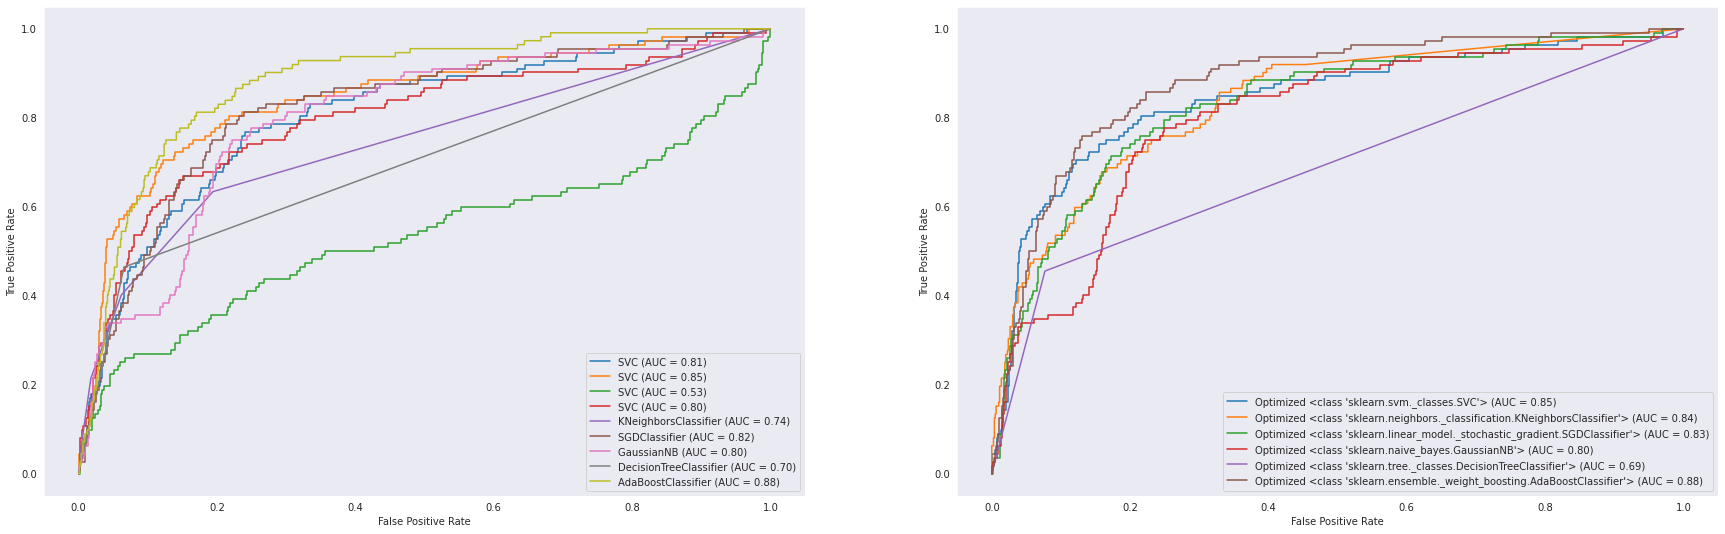

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,9))

# Plot unoptimized ROC Curves
for m in models:
  plot_roc_curve(m, X_test, y_test, ax=ax[0])
# Plot optimized ROV Curves
for m in bestModels:
  plot_roc_curve(m, X_test, y_test, ax=ax[1], name=f'Optimized {m.__class__}')
# See AUC Scores for comparison

In [21]:
from sklearn.model_selection import cross_val_score as cvs

print('According to F1 scorring method we got below scores for our machine learning models:')
# Names to be printed
modelNames = ['Linear SVM', 'Radial Basis Function SVM', 'Polynomial SVM', 'Sigmoid SVM', 'KNearestNeighbors', 'SGD', 'GaussianNB', 'DecisionTree', 'AdaBoost']
# 
modelFrame = pd.DataFrame({'modelNames': modelNames, 'modelClassificators': models})
# Iteration variable
counter = 0
# Empty metrics list
score = []
for i in modelFrame['modelClassificators']:
  # Compute weighted f1-Score
  f1_weighted = cvs(i, X_train, y_t.ravel(), scoring='f1_weighted', cv=5)
  print('Weighted F1 Score of %s Classification model is %.2f (\u00B1 %0.2f)' %(modelFrame.iloc[counter,0],f1_weighted.mean(), f1_weighted.std()))
  # Append score to list
  score.append(f1_weighted.mean())
  # Iterate
  counter+=1

According to F1 scorring method we got below scores for our machine learning models:
Weighted F1 Score of Linear SVM Classification model is 0.83 (± 0.00)
Weighted F1 Score of Radial Basis Function SVM Classification model is 0.86 (± 0.01)
Weighted F1 Score of Polynomial SVM Classification model is 0.85 (± 0.00)
Weighted F1 Score of Sigmoid SVM Classification model is 0.86 (± 0.01)
Weighted F1 Score of KNearestNeighbors Classification model is 0.87 (± 0.01)
Weighted F1 Score of SGD Classification model is 0.86 (± 0.01)
Weighted F1 Score of GaussianNB Classification model is 0.84 (± 0.01)
Weighted F1 Score of DecisionTree Classification model is 0.87 (± 0.01)
Weighted F1 Score of AdaBoost Classification model is 0.88 (± 0.01)


In [22]:
# Names to be printed
bestModelNames = ['SVM', 'kNN', 'SGD', 'NaiveBayes', 'DecisionTree', 'AdaBoost']
# Create Metric Data Frames
acc_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})
f1_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})
jaccard_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})
precision_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})
recall_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})
roc_auc_df = pd.DataFrame({'SVM': [], 'kNN': [], 'SGD': [], 'NaiveBayes': [], 'DecisionTree': [], 'AdaBoost': []})

# Crossvalidate all scoring methods
for c, i in enumerate(bestModels):
  # Pick model for list selection
  model = bestModelNames[c]
  # Store metrics into appropriate DataFrame
  acc_df[model] = cvs(i, X_train, y_t.ravel(), scoring="accuracy", cv=5)
  f1_df[model] = cvs(i, X_train, y_t.ravel(), scoring="f1_weighted", cv=5)
  jaccard_df[model] = cvs(i, X_train, y_t.ravel(), scoring="jaccard", cv=5)
  precision_df[model] = cvs(i, X_train, y_t.ravel(), scoring="precision", cv=5)
  recall_df[model] = cvs(i, X_train, y_t.ravel(), scoring="recall", cv=5)
  roc_auc_df[model] = cvs(i, X_train, y_t.ravel(), scoring="roc_auc", cv=5)

In [23]:
# Create lists for further iteration
scores = [acc_df, f1_df, jaccard_df, precision_df, recall_df, roc_auc_df]
score_names = ['Accuracy', 'F1 Weighted', 'Jaccard','Precision', 'Recall', 'ROC AUC Score']

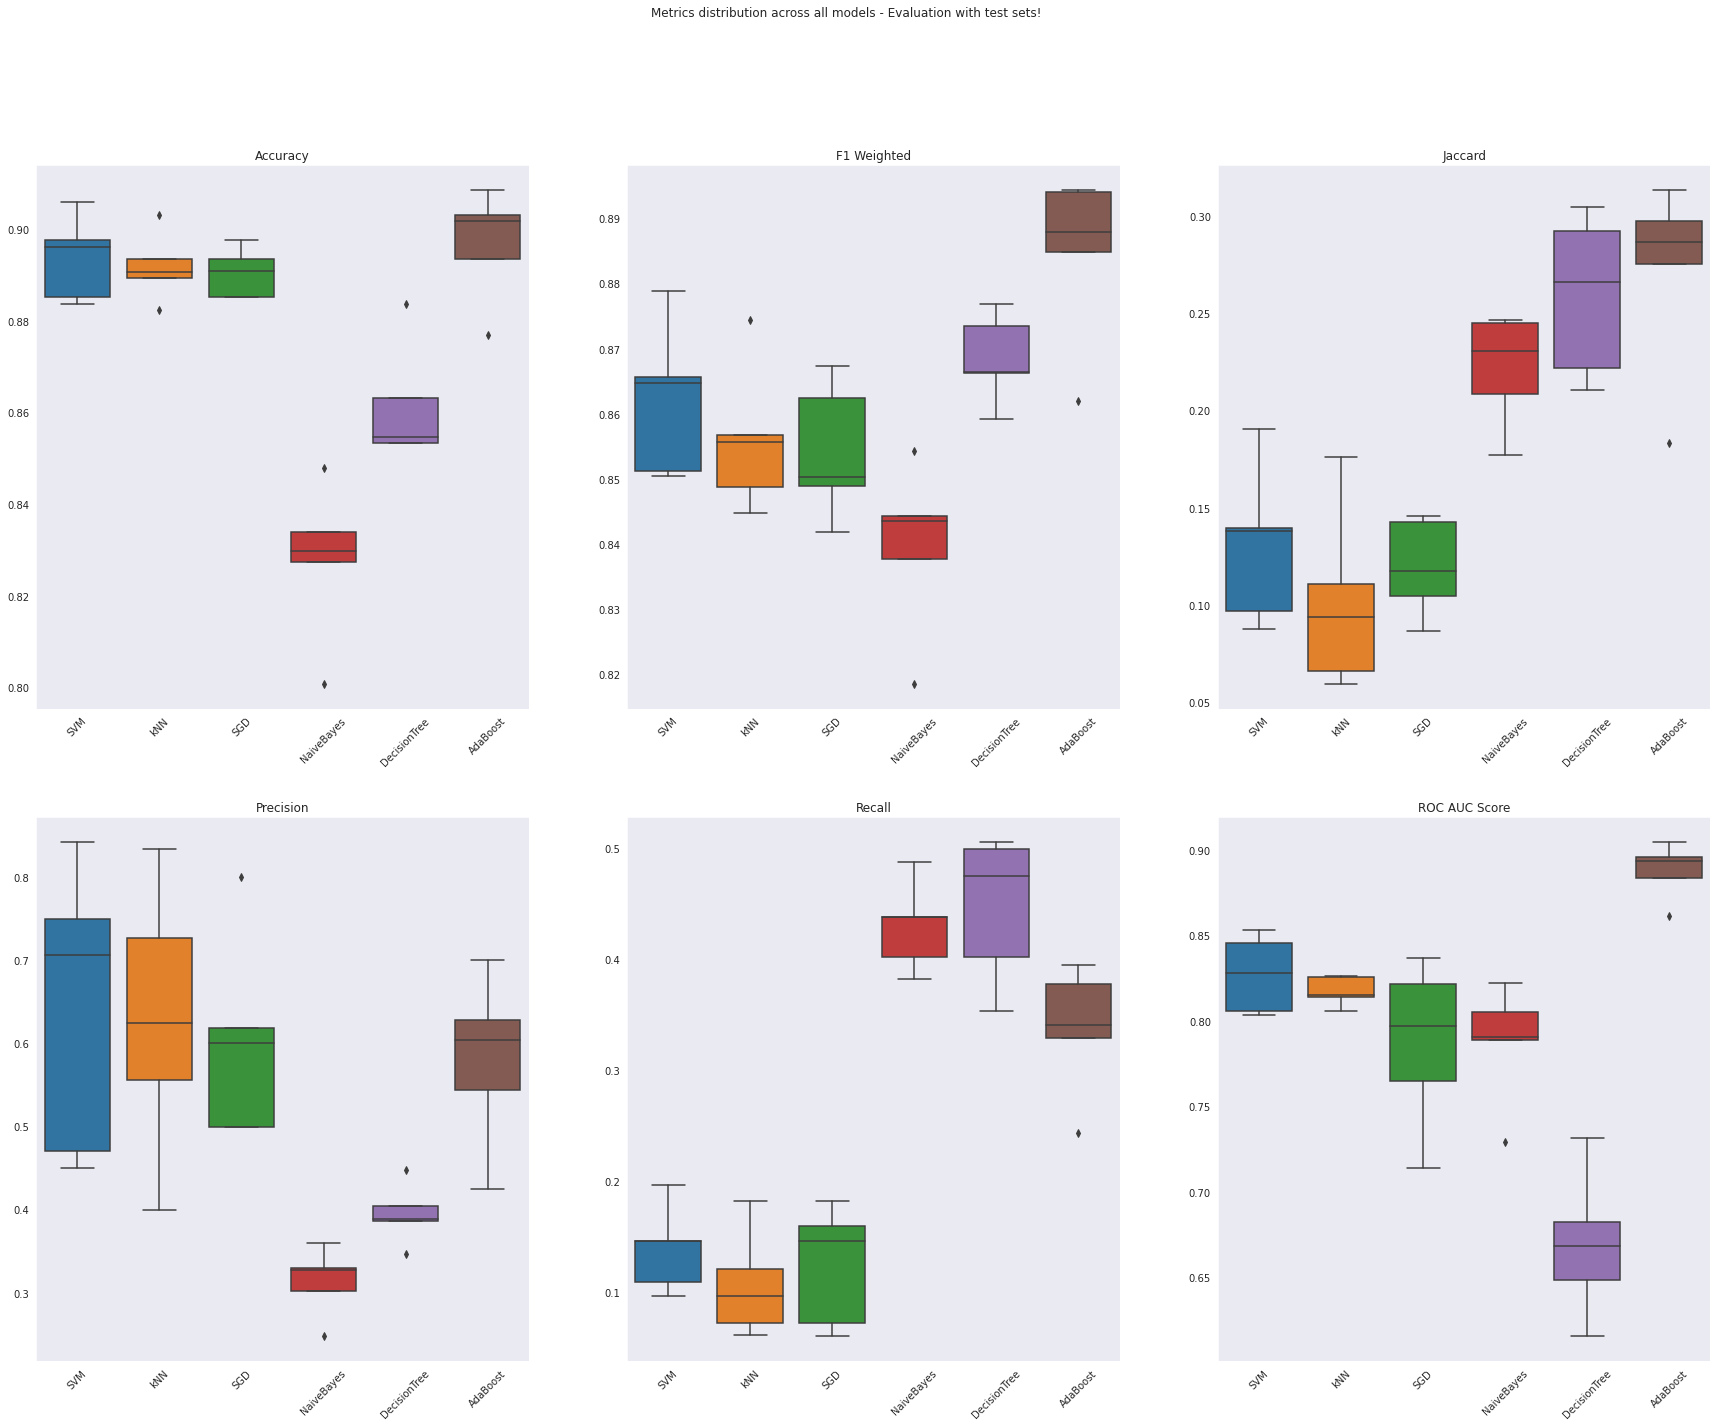

In [24]:
# Create plots for all metrics
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 22))
# Flatten axes for iteration purposes
ax = ax.flatten()

# Add Suptitle
fig.suptitle('Metrics distribution across all models - Evaluation with test sets!')

# Iterate through all metrics and add them to the plot
for i, sc in enumerate(scores):
  sns.boxplot(data=sc, ax=ax[i])
  ax[i].set_title(score_names[i])
  ax[i].tick_params('x', labelrotation=45)